<a href="https://colab.research.google.com/github/LinasEin/mia/blob/master/MIA_Machine_Learning_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Skin Lesion detection

A resnet34 implementation of a publicly accessible dermatology image analysis benchmark challenge

In [2]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import random_split
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [7]:
folder = './drive/MyDrive/Colab Notebooks/skin-lesion/'


Train image loading finished.


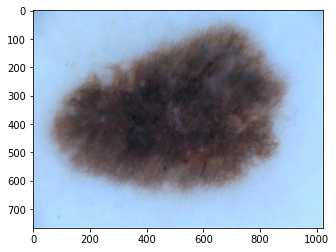

In [13]:
# Data loading
folder = './drive/MyDrive/Colab Notebooks/skin-lesion/'

df = pd.read_csv(folder+'SkinLesionTraining_GroundTruth.csv', header=None)

data = np.array(df.values)
labelClasses = data[:, 1]
labels = labelClasses
labels[labels=='malignant'] = 1.
labels[labels=='benign'] = 0.
input = data[:, 0]
input_dataset = np.array(list(zip(input, labels)))

ref = np.array(Image.open(folder+ 'SkinLesionTrainingData/' +'ISIC_0000000.jpg').convert('L'))
refShape= np.moveaxis(ref, 0, 1).shape
im_array_training = np.stack([np.array(Image.open(folder + 'SkinLesionTrainingData/' + name + ".jpg").resize(refShape)) for name in input], 0)
print("Train image loading finished.")
plt.figure(1)
plt.imshow(im_array_training[0])
plt.show()


In [3]:
# Move data to specified device memory
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader(DataLoader):
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [ ]:
# Loading into dataset
class ImageDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform
        
    def __getitem__(self, index):
        image = self.data[index]
        label = self.labels[index]
        label = torch.tensor(label, dtype=torch.float)
        label = torch.unsqueeze(label, 0)
        if self.transform:
            augmentations = self.transform(image=image)
            image = augmentations["image"]
        return image, label
    
    def __len__(self):
        return len(self.data)

# Data augmentation definition
train_transform = A.Compose(
    [
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0],
            std=[1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

VALIDATION_SPLIT = 0.15
BATCH_SIZE = 4
LEARNING_RATE = 0.0001
MAX_LEARNING_RATE = 0.01
EPOCHS = 100

dataset = ImageDataset(im_array_training, labels, train_transform)
val_size = int(VALIDATION_SPLIT * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Data loaders
train_loader = torch.utils.data.DataLoader(
                train_dataset,
                batch_size=BATCH_SIZE,
                num_workers=2,
                pin_memory=True,
                shuffle=False)
val_loader = torch.utils.data.DataLoader(
                val_dataset,
                batch_size=BATCH_SIZE,
                num_workers=2,
                pin_memory=True,
                shuffle=False)

device = get_default_device()

train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [5]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        self.expansion = 1
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        # For Resnet50
        # self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1)
        # self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        # For Resnet50
        # x = self.conv3(x)
        # x = self.bn3(x)
        x = self.relu(x)
        if self.identity_downsample:
            identity = self.identity_downsample(identity)
        x = x + identity
        x = self.relu(x)
        return x

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        # Init layers
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # ResNet34 layers
        self.layer1 = self._make_layer(block, layers[0], out_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], out_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], out_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], out_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*1, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

    def _make_layer(self, block, num_res_blocks, out_channels, stride):
        identity_downsample = None
        layers = []

        if stride != 1 or self.in_channels != out_channels * 1:
            identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels*1, kernel_size=1,
                                                          stride=stride),
                                                nn.BatchNorm2d(out_channels*1))        
        layers.append(block(self.in_channels, out_channels, identity_downsample, stride))
        self.in_channels = out_channels * 1

        for i in range(num_res_blocks - 1):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def training_step(self, batch, criterion):
        data, labels_digit = batch
        preds = self(data)
        loss = criterion(preds, labels_digit)
        return loss

    def validation_step(self, batch, criterion):
        data, labels_digit = batch
        pred = self(data)
        pred = torch.sigmoid(pred)
        pred = torch.round(pred).float()
        num_correct = (pred == labels_digit).sum()
        num_pixels = torch.numel(pred)
        return {'val_loss': num_correct/num_pixels, 'val_acc': 100 * (num_correct/num_pixels)}
    
    def validation_epoch_end(self, outputs):
        batch_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        batch_acc = torch.stack([x['val_acc'] for x in outputs]).mean()
        return {'val_loss': batch_loss.item(), 'val_acc': batch_acc.item()}

    def epoch_end(self, epoch, result):
            print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
                epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))


def ResNet34(img_channels=3, num_classes=1):
    return ResNet(Block, [3,4,6,3], img_channels, num_classes)

In [6]:
@torch.no_grad()
def evaluate(model, val_loader, criterion):
    model.eval()
    outputs = [model.validation_step(batch, criterion) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    criterion = nn.BCEWithLogitsLoss()
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch, criterion)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader, criterion)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(ResNet34(), device)
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
history = fit_one_cycle(EPOCHS, MAX_LEARNING_RATE, model, train_loader, val_loader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00043, train_loss: 0.5466, val_loss: 0.5253, val_acc: 79.4118
Epoch [1], last_lr: 0.00050, train_loss: 0.5204, val_loss: 0.4955, val_acc: 79.4118
Epoch [2], last_lr: 0.00063, train_loss: 0.5146, val_loss: 0.5072, val_acc: 79.4118
Epoch [3], last_lr: 0.00081, train_loss: 0.5196, val_loss: 0.4991, val_acc: 79.4118
Epoch [4], last_lr: 0.00104, train_loss: 0.5997, val_loss: 0.5225, val_acc: 79.4118
Epoch [5], last_lr: 0.00132, train_loss: 0.5747, val_loss: 0.5401, val_acc: 77.9412
Epoch [6], last_lr: 0.00163, train_loss: 0.5506, val_loss: 0.6153, val_acc: 75.7353
Epoch [7], last_lr: 0.00199, train_loss: 0.5831, val_loss: 0.5133, val_acc: 77.2059
Epoch [8], last_lr: 0.00238, train_loss: 0.5255, val_loss: 0.7364, val_acc: 71.8137
Epoch [9], last_lr: 0.00280, train_loss: 0.5214, val_loss: 0.5904, val_acc: 79.4118
Epoch [10], last_lr: 0.00325, train_loss: 0.5099, val_loss: 0.5430, val_acc: 79.4118
Epoch [11], last_lr: 0.00372, train_loss: 0.5041, val_loss: 3.9769, val_acc

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    plt.show()

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    plt.show()

In [ ]:
plot_accuracies(history)

In [ ]:
plot_losses(history)

In [10]:
# torch.save(model.state_dict(), folder+"SkinCancerPredictionModelResnet50.pth")
model = ResNet34()
device = get_default_device()
model.load_state_dict(torch.load(folder+"SkinCancerPredictionModel.pth", map_location=torch.device('cpu')))
model = model.to(device=device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-

In [14]:
full_training_dataset = ImageDataset(im_array_training, labels, train_transform)
full_train_loader = torch.utils.data.DataLoader(
                full_training_dataset,
                batch_size=1,
                num_workers=2,
                pin_memory=True,
                shuffle=False)
device = get_default_device()

full_train_loader = DeviceDataLoader(full_train_loader, device)


In [15]:
unique_labels,counts = np.unique(labels, return_counts=True)
print(dict(zip(unique_labels, counts))) # Huge class imbalance - ROC-AUC might not be the best measure.

{0.0: 727, 1.0: 173}


In [16]:
# Get prediction probabilities
from sklearn import metrics
model.eval()
y_pred_proba = []
for idx, (x, y) in enumerate(full_train_loader):
    x = x.to(device=device)
    with torch.no_grad():
        prob = torch.sigmoid(model(x))
        y_pred_proba.append(prob.detach().cpu().numpy())

test_labels = labels.astype(int)
y_pred_proba = np.squeeze(y_pred_proba)

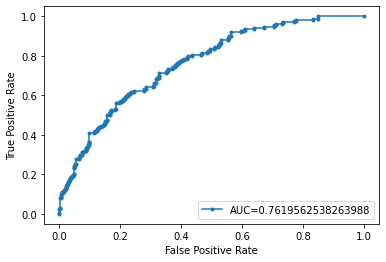

[0.15667469799518585]


[]

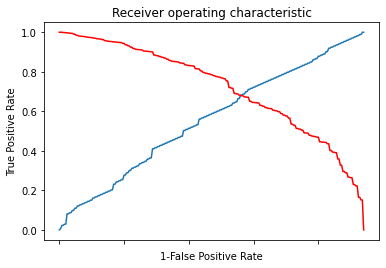

In [17]:
# ROC - AUC measure
def find_optimal_cutoff(target, predicted):
    fpr, tpr, threshold = metrics.roc_curve(target, predicted)
    auc = metrics.roc_auc_score(test_labels, y_pred_proba)
    # Plot ROC-AUC
    plt.plot(fpr,tpr, marker='.', label="AUC="+str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate' )
    plt.legend(loc=4)
    plt.show()
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
    return list(roc_t['threshold']), roc

threshold, roc = find_optimal_cutoff(test_labels, y_pred_proba)
print(threshold)

# Plot Sensitivity vs 1-Specificity
fig, ax = plt.subplots()
plt.plot(roc['tpr'])
plt.plot(roc['1-fpr'], color = 'red')
plt.xlabel('1-False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
ax.set_xticklabels([])

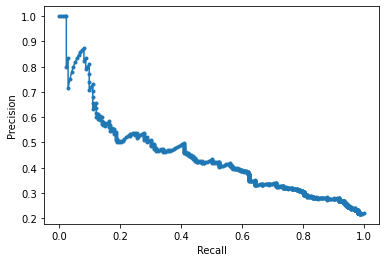

Best Threshold=0.240726, F-Score=0.479


In [18]:
# Precision-Recall measure
precision, recall, thresholds = metrics.precision_recall_curve(test_labels, y_pred_proba)
plt.plot(recall,precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# Get the best threshold
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
best_t = thresholds[ix]

In [19]:
predicted_labels_1 = [(pred > best_t).astype(float) for pred in y_pred_proba]

In [20]:
predicted_labels_2 = [(pred > 0.5).astype(float) for pred in y_pred_proba]

In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
def plot_cm(threshold, pred_labels):
    cm = confusion_matrix(test_labels, pred_labels)
    print(cm)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title(f'Confusion matrix of the classifier, threshold {threshold}')
    fig.colorbar(cax)
    _labels = ['benign', 'malignant']
    ax.set_xticklabels([''] + _labels)
    ax.set_yticklabels([''] + _labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_cm(best_t, predicted_labels_1)
plot_cm(0.5, predicted_labels_2)

In [ ]:
# f1 score
from sklearn.metrics import f1_score

f1_1 = f1_score(test_labels, predicted_labels_1)
f1_2 = f1_score(test_labels, predicted_labels_2)
print(f1_1)
print(f1_2)

In [23]:
def predict(loader, model):
    model.eval()
    res_orig = []
    res = []
    correct = 0
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > best_t).float()
            res_orig.append(preds)
            pred = 'benign' if preds==0 else 'malignant'
            print(f"SAMPLE: {idx}, Predicted class: {pred}, Ground Truth: {'benign' if y==0 else 'malignant'}")
            res.append(pred)
            correct += 1 if preds == y else 0
    accuracy = correct / len(loader)
    print(f"Accuracy on training set: {accuracy}")
    model.train()
    return res_orig, res

In [ ]:
preds, preds_text = predict(full_train_loader, model)

In [ ]:
test_imgs = os.listdir(f"{folder}SkinLesionTestData")
test_imgs = [img for img in test_imgs if img[-3:] == "jpg"]
test_imgs = sorted(test_imgs)
print(test_imgs)

In [ ]:
im_array_testing = np.stack([np.array(Image.open(folder + 'SkinLesionTestData/' + name).resize(refShape)) for name in test_imgs], 0)
print("Test image loading finished.")
plt.figure(1)
plt.imshow(im_array_testing[0])
plt.show()

In [ ]:
def predict_test(test_imgs, loader, threshold, model):
    model.eval()
    res_orig = []
    res = []
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > threshold).float()
            res_orig.append(preds)
            pred = 'benign' if preds==0 else 'malignant'
            print(f"SAMPLE: {test_imgs[idx]}, Predicted class: {pred}")
            res.append(pred)
    model.train()
    return test_imgs, res

In [ ]:
test_transform = A.Compose(
    [
        A.Normalize(
            mean=[0.0],
            std=[1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)
test_dataset = ImageDataset(im_array_testing, np.zeros(len(im_array_testing)), test_transform)


test_loader = torch.utils.data.DataLoader(
                test_dataset,
                batch_size=1,
                num_workers=2,
                pin_memory=True,
                shuffle=False)


device = get_default_device()
test_loader = DeviceDataLoader(test_loader, device)

In [ ]:
print(len(test_imgs))
print(len(test_loader))

In [ ]:
samples, predictions = predict_test(test_imgs, test_loader, best_t, model)

csv_df = {
    'image': samples,
    'prediction': predictions
}

import pandas as pd
df = pd.DataFrame(csv_df)
df.to_csv('challenge_results.csv', header=False, index=False)